# Earthquake Triangulation: Is seismic activity a harbinger of an impending eruption? 

## Before we start

### Set up the coding environment

1.   Run the code block below by either
  
  - placing your cursor in the block and pressing `shift`-`enter` on your keyboard **or** 
  - clicking the "play" button on the left-hand side

2.   Ignore the warning that pops up! 
3. Once the code block finishes running, head up to the toolbar above and click `Runtime`, then `Restart runtime` (this step is not normal but is required in this specific case)
4. Collapse this section of the notebook by clicking downward pointing triangle to the left of the "Before..." header above. 



In [ ]:
!git clone "https://github.com/cardinalgeo/earthquake-triangulation-activity.git"
!pip install -e ..
!pip install obspy

###  What is Python? What is a Jupyter Notebook?

## On to the activity! 

### Problem statement

In the time since the phreatic eruption at La Soufriere, an earthquake has been reported at seismic stations across the region. Seismic activity, in the form of earthquakes or lower amplitude "tremors," may precede eruptions, and you're concerned that the earthquake detected may indicate that a magmatic eruption is imminent. The **seismograms** below illustrates examples of such eruption-associated seismic events: 


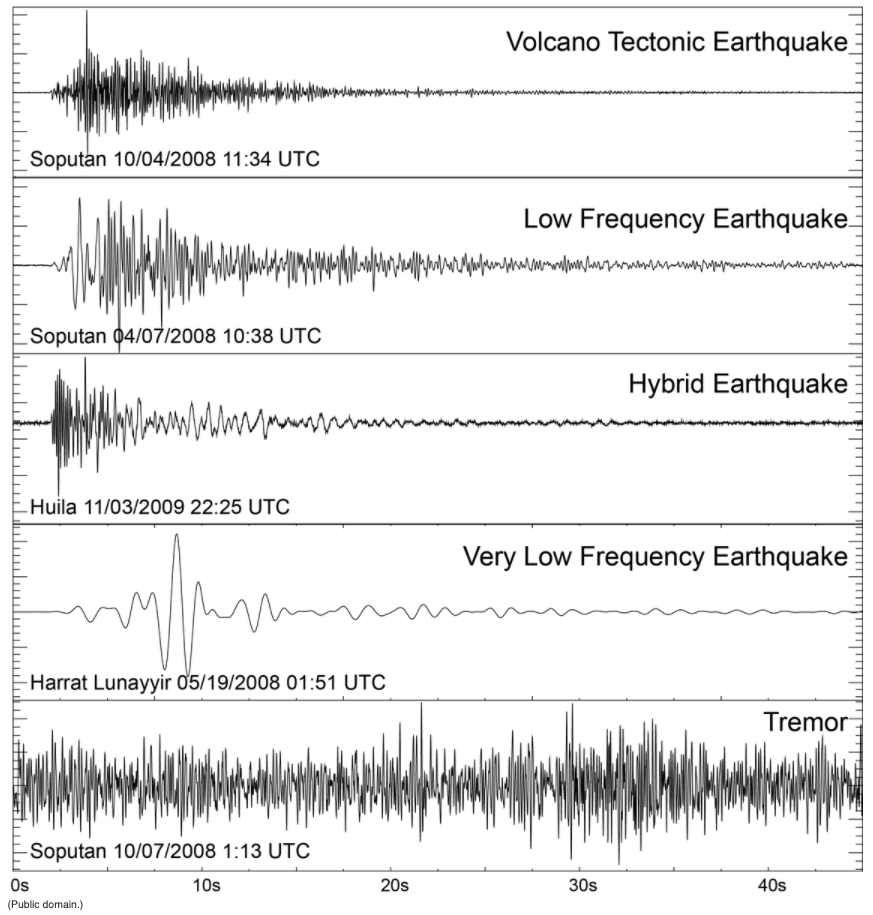

(from [USGS](https://www.usgs.gov/media/images/seismogram-signal-examples-volcanic-earthquakes-volcano-tecto))

To determine if the recorded earthquake should be of concern, you'll attempt to determine the location of its epicenter, the location on the Earth's surface below which an earthquake occurred. This can be accomplished using a method called **earthquake triangulation**. 

### Scientific context

(based in part on *Science Over Everything*'s ["Earthquake Triangulation Lab"](http://scienceovereverything.com/wp-content/uploads/2018/08/Earthquake-Triangulation-Lab.pdf))

**Earthquake triangulation** is the process of determining the epicenter of an earthquake using seismic (i.e., waveform) data collected by seismographs. Seismologists can collect data for three types of seismic waves: P-waves, S-waves, and surface waves, of which the first two are useful for earthquake triangulation. In particular, this method leverages the fact that **P-waves** ("primary waves") travel at at a greater velocity than do **S-waves** ("secondary waves"). In other words, for any given earthquake, we would expect P-waves to arrive at a seismic station before S-waves, as indicated in the seismogram below: 

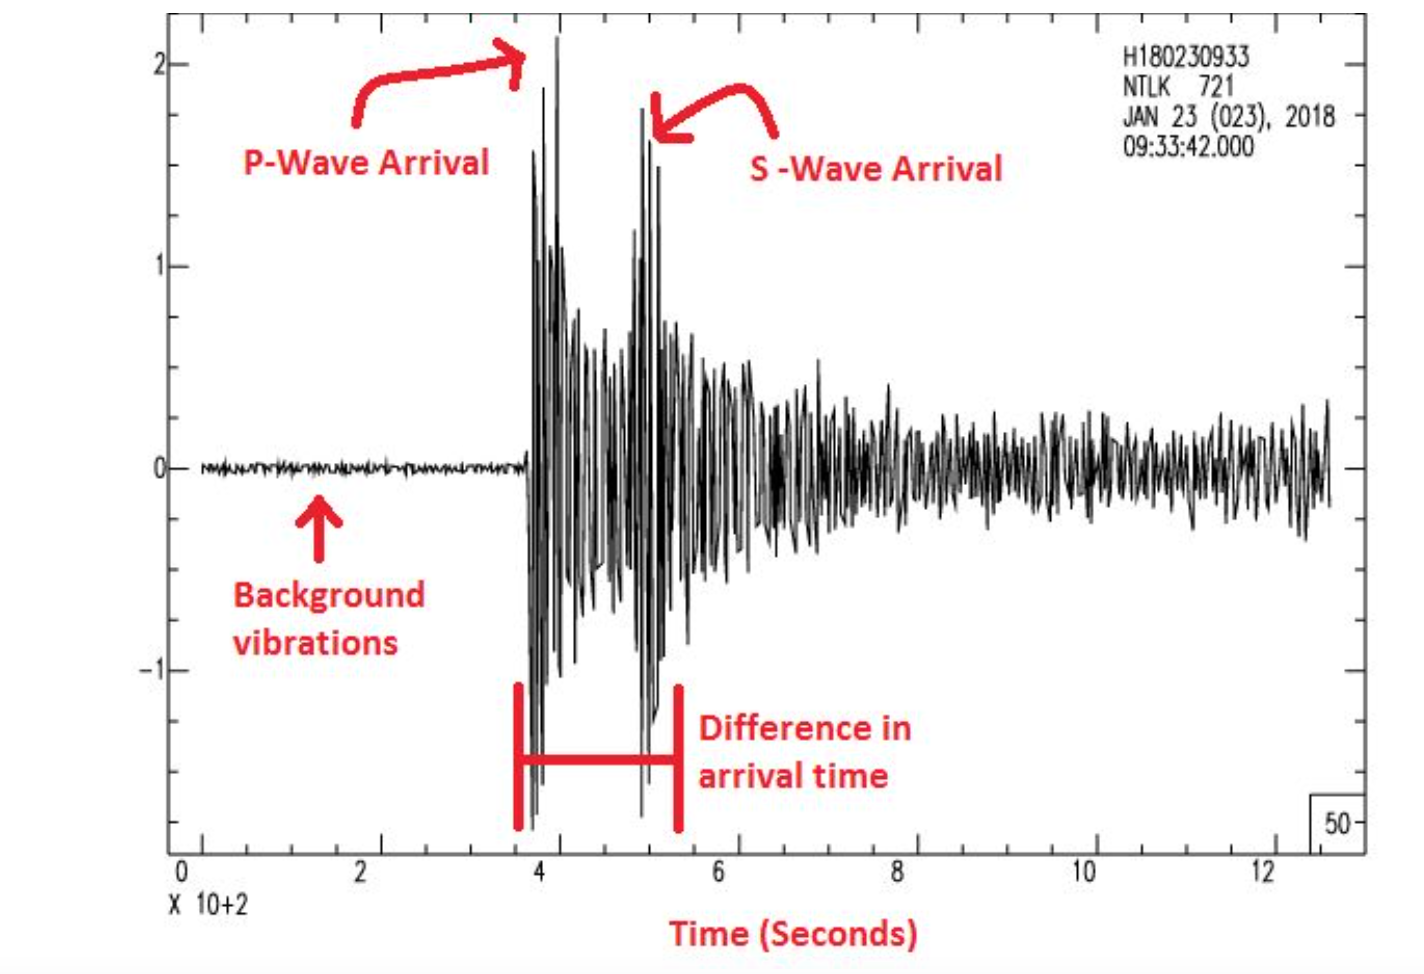


(from [Science over Everything](http://scienceovereverything.com/wp-content/uploads/2018/08/Earthquake-Triangulation-Lab.pdf), [Incorporated Research Institutions for Seismology](https://www.iris.edu/hq/inclass/software-web-app/jamaseis))


We can convert the difference in P- and S-wave arrival time to the distance between the seismic station and the earthquake epicenter. Starting with 

$$t_S = \frac{d}{v_S}, \: t_P = \frac{d}{v_P}$$

where 
- $t_S$ is the S-wave arrival time 
- $t_P$ is the P-wave arrival time 
- $v_S$ is the S-wave velocity
- $v_P$ is the P-wave velocity
- $d$ is the distance between the epicenter and the seismic station

we find the expression 

$$d = (t_S - t_P) \frac{v_P v_S}{v_P - v_S}$$

###### The derivation can be found below: 

$$t_S = \frac{d}{v_S}, \: t_P = \frac{d}{v_P}$$
$$t_S - t_P = \frac{d}{v_S} - \frac{d}{v_P}$$
$$t_S - t_P = \frac{v_P d}{v_P v_S} - \frac{v_S d}{v_S v_P}$$
$$t_S - t_P = d(\frac{v_P - v_S}{v_P v_S})$$
$$d = (t_S - t_P) \frac{v_P v_S}{v_P - v_S}$$

###### Functions
Next we'll convert the above expression into a function. **Functions** are "containers" of code that can be used over and over again. We give them **inputs** and they produce **outputs**. Run the code block below, in which we define a function called `calcEpicenterDistance`. `calcEpicenterDistance` takes the P- and S-wave arrival times as inputs and then outputs the distance to the epicenter, calculated according to the steps above. We'll use this function later on in our analysis! 

In [8]:
def calcEpicenterDistance(tP, tS): 
    # parameters
    vP = 8 # [km/s]
    vS = 4 # [km/s]

    arrival_diff = tS - tP # [s]
    factor = (vP * vS) / (vP - vS) # [km/s]
    distance = arrival_diff * factor # [km]

    return distance

Once calculated, the distance to the epicenter can be represented on a map as a circle centered at the corresponding seismic station, whose radius is equal to this "distance-to-epicenter." In other words, the epicenter lies at some point along the circumference of the cirlce. Together, multiple such circles can constrain the location of the earthquake's epicenter. 

Your **goal** is to conduct earthquake triangulation using waveform data from regional seismic stations and determine if the recorded seismic activity supports the conclusion that an imminent magmatic eruption at la Soufriere is likely. Keep in mind that you'll be communicating this conclusion to policy makers and scientists outside your field, so you should also plan to communicate the scientific context necessary for a lay audience to interpret your conclusion. 

Now let's move on to the fun part! 

### Analysis

Import the necessary packages to conduct our earthquake triangulation analysis. 



In [2]:
# package for formatting date-time data
from obspy import UTCDateTime

# local custom class and functions
from source.station_data import getStations, createMapWithStations, StationData

#### Get stations

First, we'll use the [IRIS](https://www.iris.edu/hq/) database to identify seismic stations in the region surrounding La Soufriere that were active during the period of interest.

In [3]:
# create a box to demarcate the region surrounding La Soufriere
latitude_range = [5, 18] # [°]
longitude_range = [-80, -50] # [°]

# define the time period during which seismic activity was reported
start_time = UTCDateTime("2018-08-21T21:31:42.000")
end_time = UTCDateTime("2018-08-21T21:40:42.000")

# get stations according to the above constraints
station_list = getStations(latitude_range, longitude_range, start_time, end_time)

#### Display map

Next, we'll plot the locations of the selected seismic stations on an interactive map.

In [3]:
station_map = createMapWithStations(station_list)

<a name="map_block"></a>
We can display our newly created map by simply running its name (see code block below). Zoom out on the map and explore where each station is located. Click on an icon to get each station's network and station codes.

In [4]:
station_map

#### Calculate distance to the epicenter

Now that we have a map of relevant seismic stations, let's take a look at their waveform data. Follow along with the example below, then try it on your own!

Choose a station from the map. Create a new `StationData` object for that station. This will allow you to download, store, analyze, and display waveform data collected at a particular station. In the example below, I've named the new `StationData` object `station1`, but you can call it whatever you'd like!
```python
station1 = StationData(station_list, "WC", "HATO", start_time, end_time)
```

Next, we can run `station1.plot()` to display the waveform data as three seismograms — one for each component of motion (vertical, horizontal N-S, and horizontal E-W):  

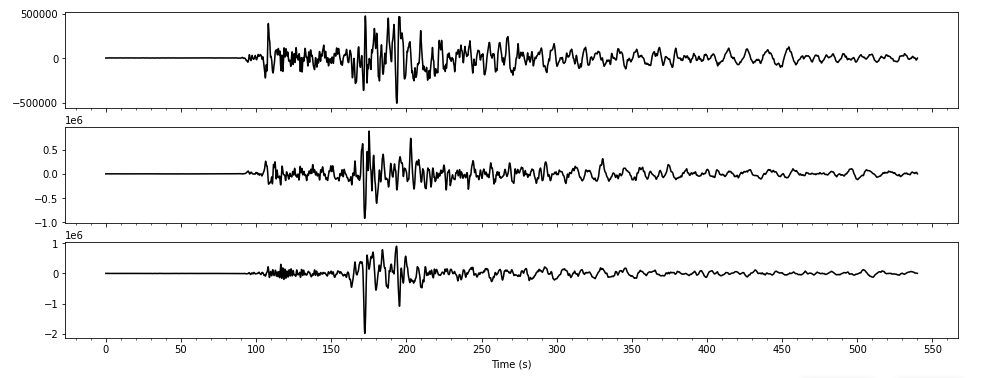

After identifying the P- and S-wave arrival times from the seismograms, you can save that information to `station1`: 
```python
station1.P_arrival_time = 90 # [s]
station1.S_arrival_time = 170 # [s]
``` 

Next, we'll calculate the distance between the station and the epicenter using the `calcEpicenterDistance` function we created earlier: 
```python
epicenter_distance = calcEpicenterDistance(station1.P_arrival_time, station1.S_arrival_time)
```
We can then save this value to `station1`: 
```python
station1.epicenter_distance = epicenter_distance
```

Finally, we'll add a circle, centered at the station of interest, to our map. The radius of the circle is the distance between the epicenter and station ( the value we just saved to `station1`). In other words, the epicenter must lie at some point along the circle's edge. 
```python
station1.addToMap(station_map)
```
We can now refresh our map to see the circle by re-running [this block](#map_block) from before: 
```python 
station_map
```

##### Next steps

Go ahead and repeat the steps above for multiple stations! As you proceed, consider the following: 

1. Do the data indicate that the epicenter is at La Soufriere? If not, where would you estimate it to be?
2. Based on your previous answer, do the data support the conclusion that an impending magmatic eruption is likely? Choose a category from those listed below to communicate this conclusion: 

  *The data...*
    - support the conclusion that an eruption is **very likely** 
    - support the conclusion that an eruption is **likely**
    - **do not** support the conclusion than an eruption is likely 
    - support the conclusion that an eruption is **unlikely**
    - support the conclusion that an eruption is **very unlikely**

3. *Food for thought*: Under ideal conditions, what is the minimum number of seismic stations necessary to constrain the location of an earthquake's epicenter?


*In summary:*

In [5]:
station1 = StationData(station_list, "WC", "HATO", start_time, end_time)
station1.plot()

In [9]:
station1.P_arrival_time = 90 # [s]
station1.S_arrival_time = 170 # [s]
station1.plot()

epicenter_distance = calcEpicenterDistance(station1.P_arrival_time, station1.S_arrival_time)
station1.epicenter_distance = epicenter_distance

station1.addToMap(station_map)

In [ ]:
station_map

##### **Your work**

*Tips:* 
- Add more code blocks by **1.)** hovering over the space between two blocks and **2.)** clicking on `+ Code`
- Use the "Table of contents" to the left to quickly navigate this notebook. 